In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

pd.options.display.float_format = '{:.2f}'.format

In [3]:
fish = pd.read_csv("ODNR_fish_stocking.csv")
fish.head()

,location_name,longitude,latitude,acres,year,species_name,stagename,numberstocked
0,LAKE ALMA,-82.52,39.14,68.00,1983,Channel Catfish,Fingerlings,7300
1,LAKE ALMA,-82.52,39.14,68.00,1983,Channel Catfish,Fingerlings,7300
2,LAKE ALMA,-82.52,39.14,68.00,1987,Channel Catfish,Fingerlings,7400
3,LAKE ALMA,-82.52,39.14,68.00,1988,Channel Catfish,Yearling,1826
4,LAKE ALMA,-82.52,39.14,68.00,1988,Channel Catfish,Yearling,1265


In [4]:
fish.describe()

,longitude,latitude,acres,year,numberstocked
count,14137.00,14137.00,14939.00,18560.00,18560.00
mean,-82.70,40.38,1085.27,1999.82,92463.23
std,1.13,0.77,2232.15,16.09,416741.52
min,-84.81,38.56,0.40,1970.00,3.00
25%,-83.66,39.82,39.00,1986.00,1066.00
50%,-82.68,40.47,157.00,2002.00,4447.00
75%,-81.56,41.03,1279.00,2014.00,25200.00
max,-80.50,41.75,16349.00,2025.00,10350000.00


In [5]:
fish.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18560 entries, 0 to 18559
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   location_name  18560 non-null  object 
 1   longitude      14137 non-null  float64
 2   latitude       14137 non-null  float64
 3   acres          14939 non-null  float64
 4   year           18560 non-null  int64  
 5   species_name   18560 non-null  object 
 6   stagename      18560 non-null  object 
 7   numberstocked  18560 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 1.1+ MB


In [6]:
fish.nunique()

location_name     494
longitude         316
latitude          315
acres             218
year               56
species_name       36
stagename           6
numberstocked    9780
dtype: int64

The dataset consists of yearly fish stocking by location with details about the fish stocked. The first year of data is from 1970 and ever year has some data.  It looks like some locations are missing data about their size and lat/lon.
Let's see if they have anything in common.

In [7]:
fish[fish['longitude'].isna()]["location_name"].value_counts()

location_name
CHAGRIN RIVER (LAKE ERIE)         374
ROCKY RIVER (LAKE ERIE)           313
GRAND RIVER (LAKE ERIE)           312
CONNEAUT CREEK (LAKE ERIE)        284
MAD RIVER (GREAT MIAMI R)         239
                                 ... 
OTTAWA NATIONAL  WILDLIFE AREA      1
MOSQUITO CREEK WILDLIFE AREA        1
PYMATUNING CREEK (MAHONING R)       1
REID PARK PONDS                     1
BEREA QUARRY                        1
Name: count, Length: 171, dtype: int64

It looks like most of the locations missing details are creeks, rivers, or areas with multiple bodies of water. This explains why they are missing lat/long and area.
Next, let's look at number of fish stocked by lake to see if how different locations compare

In [8]:
fish_by_lake = fish.groupby(["location_name", "longitude", "latitude"]).agg(total_stocked=('numberstocked', 'sum')).reset_index().sort_values(by="total_stocked", ascending=False)
fish_by_lake['total_percent'] = fish_by_lake['total_stocked'] / fish_by_lake['total_stocked'].sum() * 100
print(fish_by_lake.head())
fig = px.scatter_geo(fish_by_lake, lat='latitude', lon='longitude', scope='usa', size='total_stocked',
                     hover_name='location_name',
                     title="Total Fish Stocking in Ohio (1970-2025)",
                     color_discrete_sequence=px.colors.qualitative.Plotly)

fig.update_geos(
    visible=True, resolution=50, scope="north america",
    showcountries=True, countrycolor="Black",
    showsubunits=True, subunitcolor="Blue",
    fitbounds="locations",
    projection=dict(type="mercator", rotation=dict(lat=40, lon=-82))  # Centered on Ohio
)

fig.show()


            location_name  longitude  latitude  total_stocked  total_percent
186         MOSQUITO LAKE     -80.76     41.30      512230467          31.17
34            BERLIN LAKE     -81.00     41.05      126576842           7.70
101  GRAND LAKE ST. MARYS     -84.57     40.53      105489392           6.42
260           SENECA LAKE     -81.44     39.92       93427244           5.69
118           INDIAN LAKE     -83.88     40.47       78731053           4.79


It's clear that Mosquito Lake in northern Ohio has had the most fish stocked since 1970 at over 0.5 billion! This constitutes 31% of all fish stocked in Ohio. Let's zoom in on Mosquito Lake.

         year  total_stocked
count   55.00          55.00
mean  1997.64     9313281.22
std     16.43     4201294.96
min   1970.00      223466.00
25%   1983.50     7200000.00
50%   1998.00     9375000.00
75%   2011.50    11390949.50
max   2025.00    20050000.00


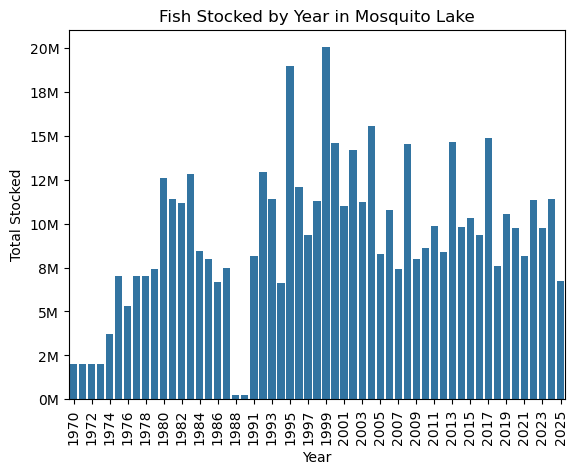

In [9]:
fish_by_year = fish[fish["location_name"] == 'MOSQUITO LAKE'].groupby(["year"]).agg(total_stocked=('numberstocked', 'sum')).reset_index()
print(fish_by_year.describe())
ax = sns.barplot(data=fish_by_year, x="year", y="total_stocked")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000000:.0f}M'))

# Reduce x-axis labels, showing only every other label
plt.xticks(ticks=range(0, len(fish_by_year['year']), 2), 
               labels=fish_by_year['year'][::2], rotation=90)
plt.xlabel("Year")
plt.ylabel("Total Stocked")
plt.title("Fish Stocked by Year in Mosquito Lake")
plt.show()

On average, 9 million fish per year are stocked in Mosquito Lake. There are a few low years around 1990 and the peak was in 1999 at 20M fish stocked.

In [10]:
fish_total = fish[fish['location_name'] == 'MOSQUITO LAKE'].groupby(['species_name']).agg(sum=('numberstocked', 'sum')).sort_values(by='sum', ascending=False).reset_index()
fish_total.head()


,species_name,sum
0,Walleye,512200467
1,Channel Catfish,20000
2,Largemouth Bass,10000


Clearly walleye are the majority. Doing some research shows that walleye are not native to Mosquito Lake. The Ohio Department of Natural Resources (ODNR) have to stock walleye to keep the popuplation up.
Only 10% of walleye in lake are born there naturally.

In [15]:
fish_by_species = fish.groupby(["species_name",  "stagename"]).agg(total_stocked=('numberstocked', 'sum')).reset_index()
fish_by_species = fish_by_species.sort_values(by="total_stocked", ascending=False)
fish_by_species['total_percent'] = fish_by_species['total_stocked'] / fish_by_species['total_stocked'].sum() * 100
fish_by_species.head(10)

,species_name,stagename,total_stocked,total_percent
103,Walleye,Fry,811082091,47.26
79,Saugeye,Fry,298079656,17.37
78,Saugeye,Fingerlings,226387309,13.19
102,Walleye,Fingerlings,98309551,5.73
109,Yellow Perch,Fry,82717267,4.82
46,Hybrid-Striped Bass,Fry,43971000,2.56
108,Yellow Perch,Fingerlings,29219448,1.70
45,Hybrid-Striped Bass,Fingerlings,16420571,0.96
93,Striped Bass (male) x White bass (female),Fry,14466000,0.84
70,Rainbow Trout,Yearling,9876570,0.58


We see ODNR mostly stock walleye fry followed by saugeye (a walleye-sauger hybrid) fry and fingerlings. Around 80% of all fish stocked are either walleye or saugeye.